In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import sklearn.model_selection as ms
cv = importlib.import_module("cv2")
import sys
import random

In [20]:
#Used for counting number of occurences of each classification
cl_count = {}
cl_images = {}

for root, dirs, files in os.walk('images/',topdown=True):
    for file in files:
        # root[7:] cuts of 'images/' in the root name, so it is just the classification name
        cl = root[7:]
        if cl_count.get(cl) == None:
            cl_count[cl] = 1
            cl_images[cl] = [cv.imread(root + '/' + file)]
        else:
            cl_count[cl] += 1
            cl_images[cl].append(cv.imread(root + '/' + file))

# Print the types of images we have
for key in cl_count.keys():
    print(key)

# Get minimum number of images in a set
m = min(cl_count.values())

# Compile minimum number of images from each set
all_images = []
for l in cl_images.values():
    all_images.extend(l[:m])

# Print number of all images
print('# of images:',len(all_images))

# Create dummies: 0 for 1st classification, 1 for 2nd, etc.
dummies = []
for i, t in enumerate(cl_images.keys()):
    dummies.extend([i] * m)

# Defines what ratio of images will be training images, <1
training_ratio = 0.9

# Split data into training and test sets
x_train, x_test, y_train, y_test = ms.train_test_split(all_images,dummies,train_size=training_ratio)
print('# of images in training set:',len(x_train))


airplanes
butterfly
Leopards
# of images: 273
273
245
245


In [79]:
# Convert all test images into grayscale
gray_train = list(map(lambda x: cv.cvtColor(x,cv.COLOR_BGR2GRAY),x_train))

# Get sift descriptors for all images
sift = cv.SIFT_create()
sifts = list(map(lambda x: sift.detectAndCompute(x,None),gray_train)) #list of tuples

#Change class_id value to correspond to image
for i, s in enumerate(sifts):
    for kp in s[0]:
        kp.class_id = i

# Get minimum number of keypoints in an image
min_keypoints = min(map(lambda x: len(x[0]), sifts))
print('min_keypoints:',min_keypoints)

# Sort the SIFT descriptors by response value in descending order
# Each image is a list of tuple pairs: keypoint and descriptor
sifts_sorted = list(map(lambda x: sorted(zip(x[0],x[1]),key=(lambda y: y[0].response),reverse=True),sifts))

# Keep only the strongest SIFT descriptors
sifts_cut = list(map(lambda x: x[:min_keypoints],sifts_sorted))

# Define methods to extract keypoint lists and numpy array of descriptors
def extract_keypoints(l):
    return list(map(lambda x: x[0], l))

def extract_descriptors(l):
    ret = np.empty((0,128),np.float64)
    for tup in l:
        ret = np.vstack((ret,tup[1]))
    return ret

60
<class 'list'>
60
type: <class 'numpy.ndarray'>
shape: (60, 128)
2


In [80]:
# Stack descriptors
descriptors = np.empty((0,128),np.float64)
keypoints = []

for image in sifts_cut:
    descriptors = np.vstack((descriptors,extract_descriptors(image)))
    keypoints.extend(extract_keypoints(image))
    
print('total number of descriptors:',descriptors.shape[0])
print('total number of keypoints:',len(keypoints))

total number of descriptors: 14700
total number of keypoints: 14700
(14700, 128)


In [23]:
# k-Means algorithm
def kmeans(kp,ds,k):
    # Choose c random centers
    rand = np.random.choice(ds.shape[0],k, replace=False)
    c = ds[rand]
    
    #Initialize data structures
    clusters = [np.empty((0,128),np.float64)] * k
    prev_clusters = [np.empty((0,128),np.float64)] * k
    keypoint_dict = {}
    
    # Define a method for comparing two cluster lists
    def clusters_equal(c1,c2):
        if len(c1) != len(c2):
            return False
        for a,b in zip(c1, c2):
            if not np.array_equal(a,b):
                return False
        return True
            
    # Loop until clusters do not change
    while True:

        # Loop through keypoints, find the closest cluster center
        for keypoint,descriptor in zip(kp,ds):
            # Get the distances between descriptor and center in feature space
            differences = c - descriptor
            distances = np.sum(differences*differences,axis=1)
            min_ind = np.argmin(distances)
            clusters[min_ind] = np.vstack((clusters[min_ind],descriptor))
            
            # Check if we have seen this cluster center before
            if keypoint_dict.get(min_ind) == None:
                keypoint_dict[min_ind] = [keypoint]
            else:
                keypoint_dict[min_ind].append(keypoint)
        
        # K-means ends when clusters do not change
        if clusters_equal(clusters,prev_clusters):
            return (c, clusters, keypoint_dict)
        
        # Save the previous cluster formation
        prev_clusters = [np.copy(i) for i in clusters]
        
        # Set cluster center to center of mass
        for i in range(k):
            c[i] = clusters[i].mean(axis=0)

        # Reset clusters and keypoints for new iteration
        clusters = [np.empty((0,128),np.float64)] * k
        keypoint_dict = {}


In [24]:
# Calculates the within cluster similarity of a set
def wcs(centers, kp):
    w = 0
    #print('kp',kp)
    for center, keypoints in zip(centers, kp):
        differences = keypoints - center
        w += np.sum(np.sum(differences*differences,axis=1))
    return w

In [ ]:
# iters = number of times we want to run k-means
# k = number of clusters
iters = 10
k = 400

best = sys.float_info.max
best_centers = []

for i in range(iters):
    # run k-means
    out = kmeans(keypoints,descriptors, k)
    
    # Calculate the within-cluster similarity
    w = wcs(out[0],out[1])
    
    # Check if the WCS is better than current best
    if w < best:
        best = w
        best_centers = out
        print('new best W:',w)
    else:
        print('no update:',w)


Text(0.5, 1.0, 'Corresponding centroid')

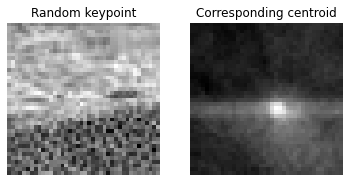

In [162]:
# Plot a keypoint and the corresponding centroid
image_num = 10
keypoint_num = 110
img=cv.drawKeypoints(gray_train[image_num],[sifts[image_num][0][keypoint_num]],img)
cv.imshow('one keypoint',img)
cv.waitKey(0)
cv.destroyAllWindows()
sifts[0][0][0]
point = sifts[image_num][0][keypoint_num].pt
point_int = (int(point[0]), int(point[1]))

#Create subplots
fig, (ax1, ax2) = plt.subplots(1,2)
plt.gray()
b = 20
ax1.set_title('Random keypoint')
ax1.imshow(gray_train[image_num][point_int[1]-b:point_int[1]+b,point_int[0]-b:point_int[0]+b])
ax1.axis('off')


#Plot corresponding centroid
differences = best_centers[0] - sifts[image_num][1][keypoint_num]
distances = np.sum(differences*differences,axis=1)
min_ind = np.argmin(distances)
cluster_keypoints = best_centers[2][min_ind]
sum_keypoint = np.zeros((2*b,2*b))

# Get padded images
gray_train_padded = list(map(lambda x: np.pad(array=x,pad_width=b+2,mode='edge'),gray_train))

# Calculate a centroid
for keypoint in cluster_keypoints:
    y,x = keypoint.pt
    y = int(y)
    x = int(x)
    class_id = keypoint.class_id
    sum_keypoint += gray_train_padded[class_id][x:x+2*b,y:y+2*b]
    
# Finish calculating the centroid and plot
sum_keypoint /= len(cluster_keypoints)
sum_keypoint
ax2.imshow(sum_keypoint)
ax2.axis('off')
ax2.set_title('Corresponding centroid')

In [163]:
# Create histograms
k=400
histograms = np.zeros((len(x_train),k),dtype=np.uint8)
for key, values in best_centers[2].items():
    for val in values:
        histograms[val.class_id,key] += 1
        

Text(0.5, 1.0, 'Histogram of image')

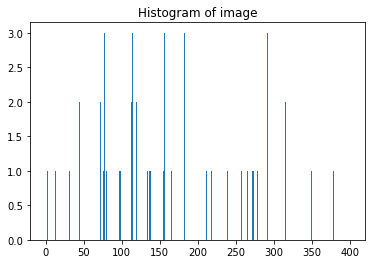

In [164]:
# Show an example histogram
h = histograms[174]
plt.bar(np.arange(len(h)),h)
plt.title('Histogram of image')

In [31]:
print('# of histograms:',histograms.shape[0])
print('# of y-values:',len(y_train))

# of histograms: 245
# of y-values: 245


In [58]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Train the SVM based on the histograms
classifier = OneVsRestClassifier(SVC()).fit(histograms, y_train)

# Convert all training images into grayscale
gray_test = list(map(lambda x: cv.cvtColor(x,cv.COLOR_BGR2GRAY),x_test))

# Get sift descriptors for all images
sifts_test = list(map(lambda x: sift.detectAndCompute(x,None),gray_test)) #list of tuples

#Keep the same number of min keypoints as previously

# Sort the SIFT descriptors by response value in descending order
# Each image is a list of tuple pairs: keypoint and descriptor
sorted_test = list(map(lambda x: sorted(zip(x[0],x[1]),key=(lambda y: y[0].response),reverse=True),sifts_test))

# Keep only the strongest SIFT descriptors
cut_test = list(map(lambda x: x[:min_keypoints],sorted_test))

# Extract test descriptors
test_descriptors = list(map(extract_descriptors,cut_test))

# Reuses code from k-means algorithm: finds the closest cluster center
def gen_test_histogram(x):
    hist = np.zeros(k)
    for descriptor in x:
        differences = best_centers[0] - descriptor
        distances = np.sum(differences*differences,axis=1)
        min_ind = np.argmin(distances)
        hist[min_ind] += 1
    return hist

# Calculate histograms of test set and predict the output
test_histograms = list(map(gen_test_histogram,test_descriptors))
final_output = classifier.predict(test_histograms)

# Calculate the confusion matrix
names = list(cl_count.keys())
cm = pd.DataFrame(confusion_matrix(y_test,final_output))
cm.columns = pd.MultiIndex.from_product([["Prediction"], names])
cm = cm.set_axis(pd.MultiIndex.from_product([["Actual"], names]),axis=0)

# Output confusion matrix
cm

Prediction                   
                  airplanes butterfly Leopards
Actual airplanes          8         2        0
       butterfly          1         5        3
       Leopards           0         0        9

(-0.5, 127.5, 191.5, -0.5)

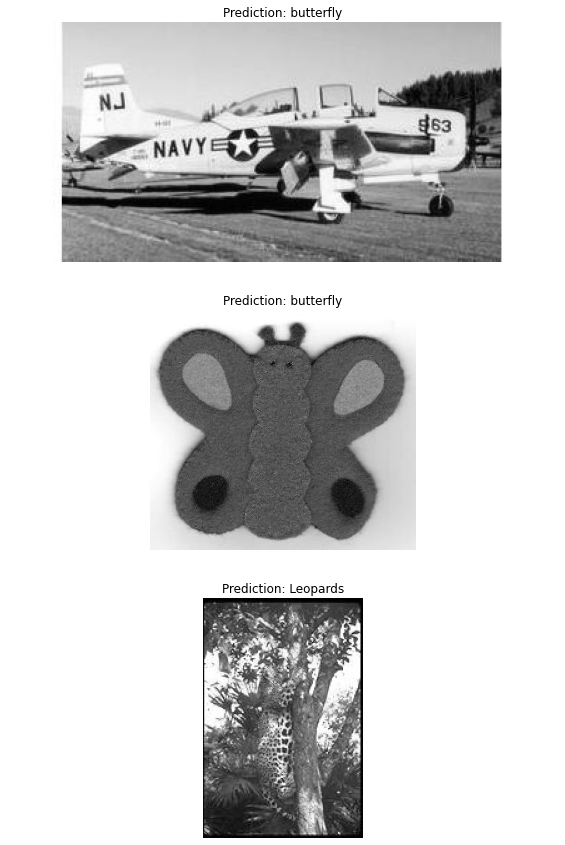

In [165]:
# Find the first occurence of output values 0,1,2
out_0 = y_test.index(0)
out_1 = y_test.index(1)
out_2 = y_test.index(2)

# Create plots, label with predicted output
fig, (ax1,ax2,ax3) = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(15)

ax1.set_title('Prediction: ' + names[final_output[out_0]])
ax1.imshow(gray_test[out_0])
ax1.axis('off')
ax2.set_title('Prediction: ' + names[final_output[out_1]])
ax2.imshow(gray_test[out_1])
ax2.axis('off')
ax3.set_title('Prediction: ' + names[final_output[out_2]])
ax3.imshow(gray_test[out_2])
ax3.axis('off')

In [157]:
# Calculate accuracy of model
total = np.sum(np.sum(cm))
cm_numpy = cm.to_numpy()
incorrect = total - cm_numpy[0,0] - cm_numpy[1,1] - cm_numpy[2,2]
accuracy = (total - incorrect) / total * 100
print("Model accuracy:",str(accuracy)+"%")

Model accuracy: 78.57142857142857%
